In [1]:
%matplotlib inline
import scipy.sparse as spr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import scipy as spy
import scipy.spatial
import time
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
def non_maxsup(pic=None,angle=None):
    result = np.zeros(np.shape(pic))
    g = lambda x: bool(abs(x)//(np.pi/4))+0
    
    for i in np.arange(1,len(result[:,0])-1):
        for j in np.arange(1,len(result[0])-1):
            theta=angle[i,j]
            
            if theta == 0:
                a=pic[i,j+1]
                b=pic[i,j-1]
            
            elif abs(theta) <= np.pi/4:
                a= pic[i,j+1] * (1-np.sin(abs(theta))) + pic[i+int(abs(theta)//theta),j+1] * np.sin(abs(theta))
                b= pic[i,j-1] * (1-np.sin(abs(theta))) + pic[i-int(abs(theta)//theta),j-1] * np.sin(abs(theta))
            
            else:
                a= pic[i+int(abs(theta)//theta),j+1] * np.cos(abs(theta)) +  pic[i+int(abs(theta)//theta),j] * (1-np.cos(abs(theta)))
                b= pic[i-int(abs(theta)//theta),j-1] * np.cos(abs(theta)) +  pic[i-int(abs(theta)//theta),j] * (1-np.cos(abs(theta)))
            
            if pic[i,j] >= a and pic[i,j] >= b:
                result[i,j]=pic[i,j]
    return(result)

########################### ORDERING THE POINTS

def checkany(tocheck=None,require=None): # Any "require" is in "tocheck"?
    try:
        a=[tuple(n) for n in tocheck]
        b=set([tuple(n) for n in require])
    except:
        a=[(n) for n in tocheck]
        b=set([(n) for n in require])
    urn=[i in b for i in a]
    return(any(urn), urn)

def checkany2(tocheck=None,require=None): # Any "require" is in "tocheck"?
    try:
        a=set([tuple(n) for n in tocheck])
        b=set([tuple(n) for n in require])
    except:
        a=set([(n) for n in tocheck])
        b=set([(n) for n in require])
    return(bool(a-b))

def get_neighbor(edge=None, graph=None, omit=None ): #graph is binary matrix
    hit=[]
    around=np.array([(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)])
    for k in edge :
        surround=[tuple(np.array(k)+i) for i in around]
        temp_hit=[i for i in surround if graph[i[0]][i[1]] == 1 and i  not in omit ]          
        hit=list(set(hit+temp_hit))
    return(hit)

def findline(points=None, graph=None):  #point is coordinates in R2, graph is binary graph of 1 on matrix coordinates in R2
    line=[]
    ends=[points]
    while len(ends) != 0:
        line=line+ends
        ends=get_neighbor(ends,graph,line)
    return(line)

def connection(pointA=None, pointB=None):  #points in matrix coordinates, from A to B
    Ai=pointA[0]>pointB[0]
    Aj=pointA[1]>pointB[1]
    if pointB[1]-pointA[1] == 0:
        return([(i,pointA[1]) for i in range(pointA[0],pointB[0],-2*Ai+1)  ][1:])
    elif pointB[0]-pointA[0] ==0:
        return([(pointA[0],i) for i in range(pointA[1],pointB[1],-2*Aj+1)  ][1:])
    else:
        link=[(pointA[0] + (1-2*Ai)*i ,pointA[1] + (1-2*Aj)*i  ) for i in range(min(abs(pointA[0]-pointB[0]),abs(pointA[1]-pointB[1]))) ]
        if abs(link[-1][1] - pointB[1])==1 :
            s=link[-1][0] >= pointB[0]
            return(link[1:]+[(i,link[-1][1]) for i in range(link[-1][0],pointB[0],-2*s+1)  ][1:])
        else:
            s=link[-1][1] >= pointB[1]
            return(link[1:]+[(link[-1][0],i) for i in range(link[-1][1],pointB[1],-2*s+1)  ][1:])

def connectagraph(graph=None): #graph is binary matrix , line0 in matrix coordinates
    graph_coor=list([tuple(l) for l in np.transpose(np.nonzero(graph == 1))])
    connected=findline(graph_coor[np.argsort(abs(np.array(convertcomplex(graph_coor))))[0]],graph)
    
    graph_coor=list(set(graph_coor) - set(connected))
    while len(graph_coor) != 0:
        
        #start_time = time.time()
        dist=spy.spatial.distance.cdist(connected,graph_coor)  #(i,j) of the resulting matrix is the distance between ith and jth terms
        #print(time.time() - start_time)

        
        minpair = np.transpose(np.nonzero(dist==np.amin(dist)))[0]
        connected=connected+connection(connected[minpair[0]],graph_coor[minpair[1]])+findline(graph_coor[minpair[1]],graph)
        graph_coor=list(set(graph_coor) - set(connected))

    return(connected)


########################revisit to add offset points for retracing######################

def convertcomplex(thelist=None):
    if thelist[0] is complex:
        return([tuple((i.real,i.imag)) for i in thelist])
    else:
        return([complex(*i) for i in thelist])

def getadjm(line=None): #line is list of complex number (matrix coordinates)
    l=len(line)
    graph=np.zeros([l,l])
    for k in range(l):
        neighborhood=np.array([-1-1j,-1,-1+1j,-1j,+1j,1-1j,1,1+1j])+line[k]
        temp_hit=set(neighborhood)-(set(neighborhood) - set(line))
        for i in temp_hit:
            graph[k][line.index(i)]=1   
    return(graph)

def getpath_adjm(adjm=None, starting=None, ignore=None): #starting is a complex number in line
    ID=np.arange(len(adjm))
    path=[starting]
    current=path
    while list(current) != list():
        temp_current=np.hstack([ID[adjm[i]==1] for i in current])
        current=list({i for i in temp_current if (i not in set(ignore)) and (i not in set(path)) })
        path= path + current
    return(path)

def shortestpath(A=None, B=None, graph=None,prede=None): 
    ###A and B are the nth elements of the lsit, list of complex numbers  
    path=[B]
    while B != -9999:
        B=prede[A][B]
        path=path+[B]
    return(path[:-1][::-1]) ###Return list of complex number inclusive



def decision(adjm=None, point=None, choices=None, visits=None):  ####matrix coordinates, points are nth elements in list
    
    if len(choices-visits)==1 :
        return(list(choices-visits)[0])
    
    else:
        branch=[]
        possible_path=list(choices-visits)

        
        for k in possible_path:    # order in possible_path corresponds to order in branch
            path=getpath_adjm(adjm,k,list(visits)+possible_path)
            branch = branch + [len(path)] 
        
        return(possible_path[np.argmin(branch)])

    
def ordering(line=None,startpoint=None): ####startpoint is a complex number, line is list of complex numbers
    startpoint=line.index(startpoint)
    ordered=[startpoint] #ordered can't be a set
    current=startpoint
    IDD=np.arange(len(line))
    adjm=getadjm(line)
    neighborhood=set(IDD[adjm[startpoint]==1])
    shortest=spr.csgraph.shortest_path(adjm,return_predecessors=True)

    while len(set(IDD)-set(ordered)) != 0 :

        if len( neighborhood - set(ordered) ) >= 1:
            #start_time = time.time()

            current=decision(adjm,current,neighborhood,set(ordered))
            ordered=ordered + [current]

            #print(time.time() - start_time)
        else:
            
            B= np.argmin(shortest[0][current]+(np.array(checkany(line,np.array(line)[ordered])[1])*999999))
            ordered = ordered + list(shortestpath(current,B,line,shortest[1])[1:])
            current=B
        neighborhood=set(IDD[adjm[current]==1])
    return(ordered)


def getorderpoints(bitmap=None,linked=None): #linked is list of tuple
    line0=findline(linked[0],bitmap)
    
    linked=[complex(*i) for i in linked]
    
    
    unlinked=list([complex(*l) for l in np.transpose(np.nonzero(bitmap == 1))])
    Adjm=getadjm(linked)
    adjm_notlink=getadjm(unlinked)
    shortestmap=spr.csgraph.shortest_path(Adjm,return_predecessors=True)
    
    connected= [ (line0[i][0]+line0[i][1]*1j) for i in ordering(convertcomplex(line0),linked[0]) ]
    
    graph_coor=list(set(unlinked) - set(connected))
    
    while len(graph_coor) != 0:
        dist=np.abs(np.array(graph_coor)[:,None]-np.array(connected)[None,:])
        
        minpair = np.transpose(np.nonzero(dist==np.amin(dist)))[0]
        connectB= np.array(graph_coor)[minpair[0]]
        connected=list(connected) + list(np.array(linked) [ shortestpath(linked.index(connected[-1]),linked.index(connectB),linked,shortestmap[1]) ][1:])     
        newline=np.array(unlinked)[getpath_adjm(adjm_notlink,unlinked.index(connectB),[])]
        orders=ordering(list(newline), connectB)
        connected=connected + list(newline[orders][1:])
        print(len(graph_coor))
    
        graph_coor=list(set(graph_coor) - set(connected))
    return(connected)

##############    FOURIER

def drawcirc(xy=None, r=None, angle0=None):
    return([(xy[0]+r*np.cos(i),xy[1]+r*np.sin(i)) for i in np.linspace(angle0,2*np.pi+angle0,int(r*5))  ])

def connectcirc(start=None,r=None, angle=None):
    points=[start]
    for k in np.arange(len(r)):
        line=lambda x: np.tan(angle[k])*x+(points[-1][1]-points[-1][0]*np.tan(angle[k]))
        branch= [ (x,line(x)) for x in np.linspace(points[-1][0],points[-1][0]+r[k]*np.cos(angle[k]),int(r[k]/2))  ]
        circ= drawcirc(points[-1],r[k],angle[k])[1:]
        points=points+ branch + circ
    return(points)

def getcircles(number=None,fft=None,t=None):
    fft=fft/len(fft)
    start=(fft[0].real,fft[0].imag)
    fftorder=np.argsort(abs(fft))[::-1]
    r=abs(fft)[fftorder][1:number]
    angle=np.array([ (t*2*np.pi*i)/len(fft) for i in fftorder[1:number] ])+np.angle(fft)[fftorder][1:number]
    
    return(connectcirc(start,r,angle))

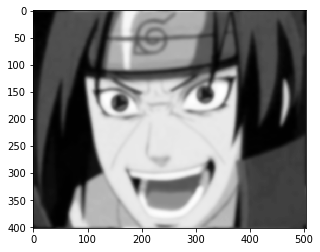

In [227]:


##Load pic
img=mpimg.imread('itab.png')

ysize = img[:,:,1].shape[0] 
xsize = img[:,:,1].shape[1] 

mygrey=np.zeros(np.shape(img[:,:,0]))
for i in range(ysize):
    for j in range(xsize):
        mygrey[i,j]=img[i,j][0] * 299/1000 + img[i,j][1] * 587/1000 + img[i,j][2] * 114/1000

##Smoothness
sigma = 3

#####################################################################


y = np.outer(((np.arange(ysize) + (ysize // 2)) % ysize) - (ysize // 2), np.ones(xsize))
x = np.outer(np.ones(ysize), ((np.arange(xsize) + (xsize // 2)) % xsize) - (xsize // 2))

kernel = np.exp(- 0.5 * (x**2 + y**2) / sigma**2) / (np.pi * 2. * sigma**2)
#plt.imshow(kernel)

kernel_ft = np.fft.rfft2(kernel)
data_ft = np.fft.rfft2(mygrey)

smoothed = np.fft.irfft2(kernel_ft * data_ft)
plt.imshow(smoothed,cmap="Greys_r")


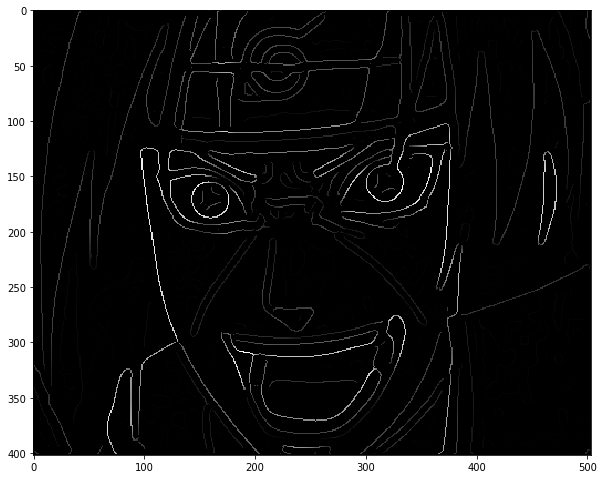

In [228]:
#np.gradient output change in row row (y) then change in column (x)
#(i,j) element is same as (y, x) element


Gy, Gx=np.gradient(smoothed) 

Grad_mag=np.sqrt(Gy**2+Gx**2)

Grad_angle=np.zeros(np.shape(smoothed))
for i in np.arange(len(smoothed[:,0])):
    for j in np.arange(len(smoothed[0])):
        if Gx[i,j] == 0:
            if Gy[i,j] < 0:
                Grad_angle[i,j]= -np.pi/2
            else:
                Grad_angle[i,j]= np.pi/2
        else:
            Grad_angle[i,j]=np.arctan(Gy[i,j]/Gx[i,j])

plt.figure(figsize=(10,10))
A1=non_maxsup(Grad_mag,Grad_angle)
plt.imshow(A1,cmap=plt.cm.gray)


(0, 0.06)

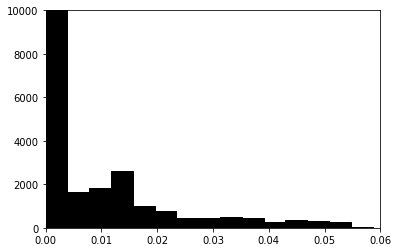

In [234]:
##### Intensity Histogram

plt.hist(A1.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.ylim(0,10000)
plt.xlim(0,0.06)

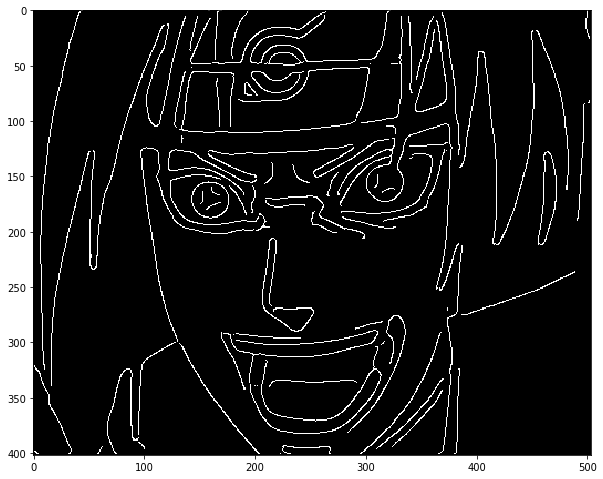

In [238]:
####Double Thresholding values

maxval=0.01
minval=0


A2=np.zeros(np.shape(A1))


for i in np.arange(len(smoothed[:,0])):
    for j in np.arange(len(smoothed[0])):
        if A1[i,j] > maxval:
            A2[i,j]=1
        elif A1[i,j] > minval:
            A2[i,j]=0.2
            
A3=np.array(A2[:])
A4=np.array(A2[:])

for i in np.arange(len(smoothed[:,0])):
    for j in np.arange(len(smoothed[0])):
        neighbor=A3[i-1:i+2,j-1:j+2]
        if 1 in neighbor and A3[i,j] >0 :
            A3[i,j]=1
        else:
            A3[i,j]=0

for i in np.arange(len(smoothed[:,0]))[::-1]:
    for j in np.arange(len(smoothed[0]))[::-1]:
        neighbor=A4[i-1:i+2,j-1:j+2]
        if 1 in neighbor and A4[i,j] >0 :
            A4[i,j]=1
        else:
            A4[i,j]=0

for i in np.arange(len(smoothed[:,0])):
    for j in np.arange(len(smoothed[0])):
        if A3[i,j] == 1 or A4[i,j]== 1:
            A4[i,j]=1

        
plt.figure(figsize=(10,10))
plt.imshow(A4,cmap="Greys_r")

In [239]:
start_time = time.time()
linkedgraph=connectagraph(A4)
print(time.time() - start_time)
len(linkedgraph)

27.09997320175171


9892

In [27]:
def bridging(graph=None): #graph is binary matrix , line0 in matrix coordinates
    graph_coor=list([tuple(l) for l in np.transpose(np.nonzero(graph == 1))])
    connected=findline(graph_coor[np.argsort(abs(np.array(convertcomplex(graph_coor))))[0]],graph)
    bridge_pair=[]
    graph_coor=list(set(graph_coor) - set(connected))
    while len(graph_coor) != 0:
        
        #start_time = time.time()
        dist=spy.spatial.distance.cdist(connected,graph_coor)  #(i,j) of the resulting matrix is the distance between ith and jth terms
        #print(time.time() - start_time)

        
        minpair = np.transpose(np.nonzero(dist==np.amin(dist)))[0]
        bridge_pair=bridge_pair+[[minpair[0],len(connected)]]
        connected=connected+findline(graph_coor[minpair[1]],graph)
        graph_coor=list(set(graph_coor) - set(connected))
        
        
        
    return(connected,bridge_pair)

bridges=bridging(A4)

In [136]:
len(bridges[0])

1496

In [240]:
T=convertcomplex(linkedgraph)
Tm=getadjm(T)

In [241]:
predec=spr.csgraph.shortest_path(Tm,return_predecessors=True)
Torder=spr.csgraph.depth_first_order(Tm,0)

In [242]:
#connected=getorderpoints(A4,linkedgraph)
Neworder=[Torder[0][0]]
for i in Torder[0][1:]:
    current=Neworder[-1]
    if Tm[current][i] == 1 :
        Neworder= Neworder + [i]
    else:
        path=shortestpath(current,i,T,predec[1])[1:]
        Neworder= Neworder + path
orderT=np.array(T)[Neworder]
len(orderT)

17417

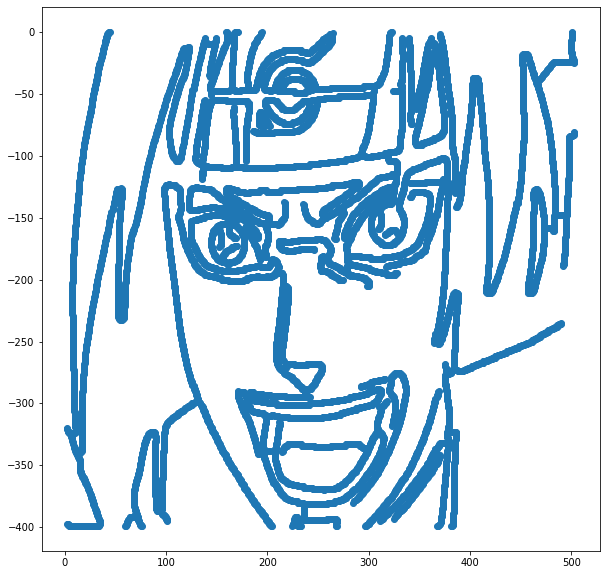

In [243]:
#line=[tuple([i.real,i.imag]) for i in connected[::10] ]
#line=findline([280,110],A4)
#line=linkedgraph
line=[tuple([i.real,i.imag]) for i in orderT]


    
plt.figure(figsize=(10,10))    
plt.scatter([line[i][1]+1 for i in range(len(line)) ],[1-line[i][0] for i in range(len(line))],lw=1)
plt.show()

# Fourier 2

In [245]:
zt=np.array([((i.imag)+(ysize-i.real)*1j) for i in orderT[::10]])
L=len(zt)
print(L)

def pic_func(t=None): 
    slope=zt[np.mod(np.ceil(t),L).astype(int)]-zt[np.mod(np.floor(t),L).astype(int)]
    return(zt[np.mod(np.floor(t),L).astype(int)]+slope*(t-np.floor(t)))


1742


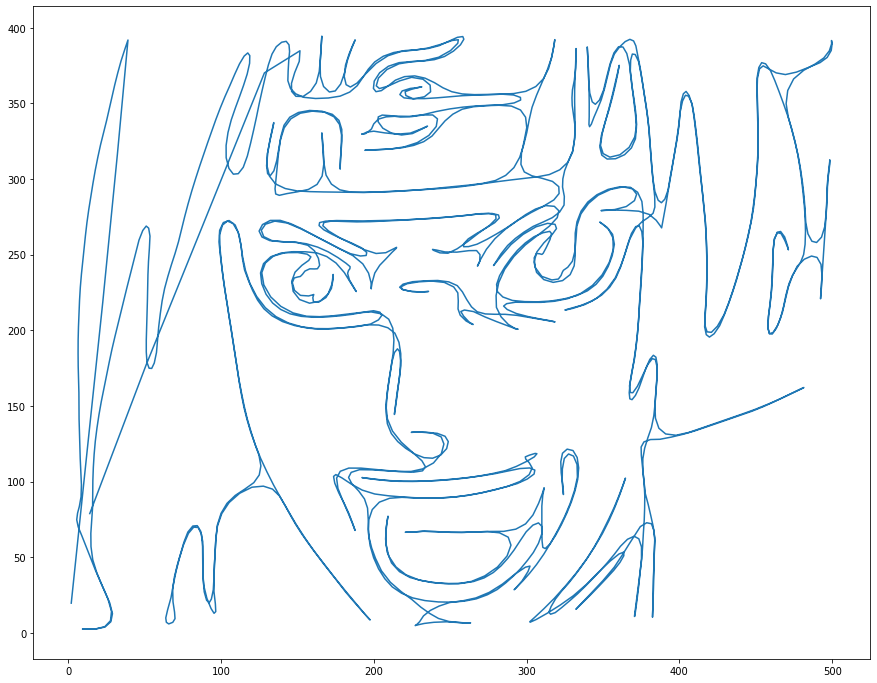

In [302]:
#datas = fourier_approx(30,pic_func,L,np.linspace(0,L,1000))

data=np.convolve([pic_func(x) for x in np.linspace(0,L,10000)],[1/n for n in 20*np.ones(20)])[::5]

x=data.real
y=data.imag
plt.figure(figsize=(15,12))
plt.plot(x,y)
#plt.plot(np.real(zt),np.imag(zt))
plt.show()

# Fourier!!!

In [303]:
#zt=np.array([((i.imag+1)+(570-i.real)*1j) for i in connected[::10]])
A=np.fft.fft(data)
print(len(A))

2004


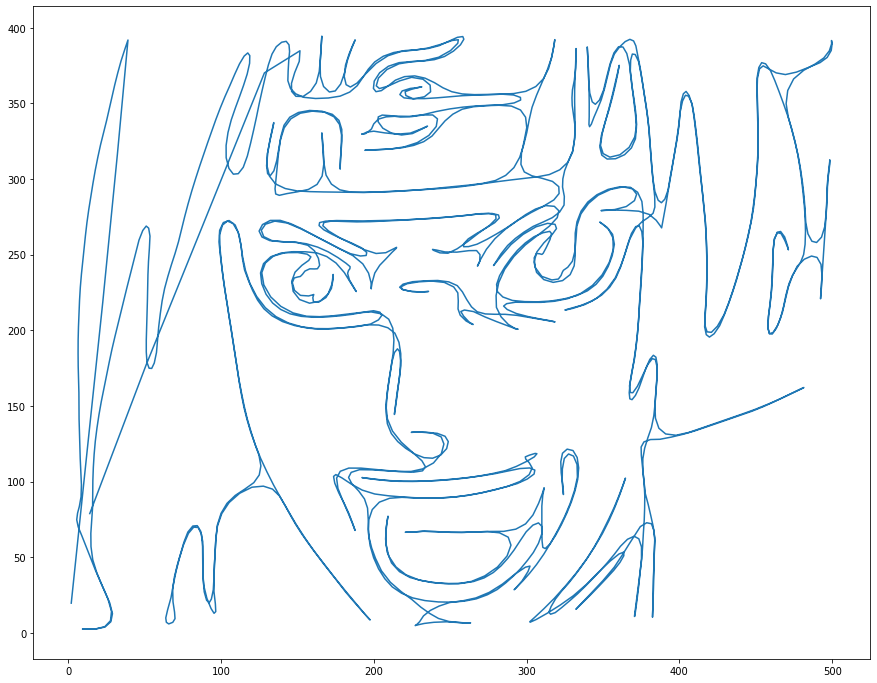

In [305]:
approx= lambda x : sum([(A[i]*np.exp((1j*x*2*np.pi*i)/len(A)))/(len(A)) for i in np.arange(0,len(A),1) ])

n=np.arange(len(A))
datas=approx(n)

x=datas.real
y=datas.imag

#x=np.real(newzt)
#=np.imag(newzt)

plt.figure(figsize=(15,12))
plt.plot(x,y)
plt.show()

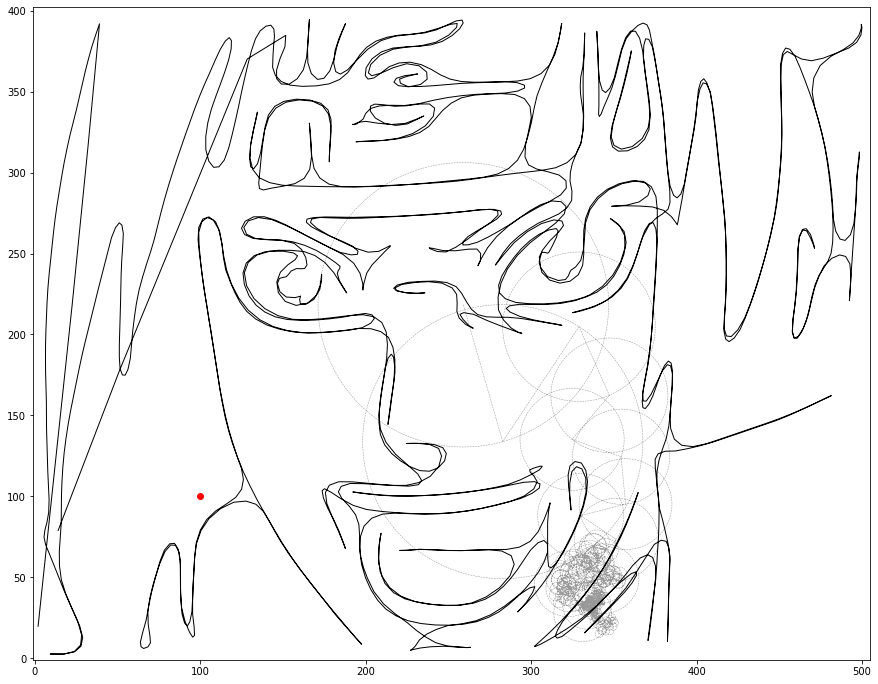

In [304]:
K=getcircles(500,A,502)

fig = plt.figure(figsize=(15,12))
#ax = plt.axes(xlim=(-10, 290), ylim=(-5,570))
p1 = fig.add_subplot(111)

p1.set_xlim([-1, xsize])
p1.set_ylim([-1,ysize])

line4,=p1.plot(np.array(K)[:,0],np.array(K)[:,1],"grey",lw=0.5,ls="--",alpha=0.8)
line5,=p1.plot(x,y,"black", lw=1,alpha=1)
line6=p1.scatter([100],[100], c='r', marker='o')
plt.show()

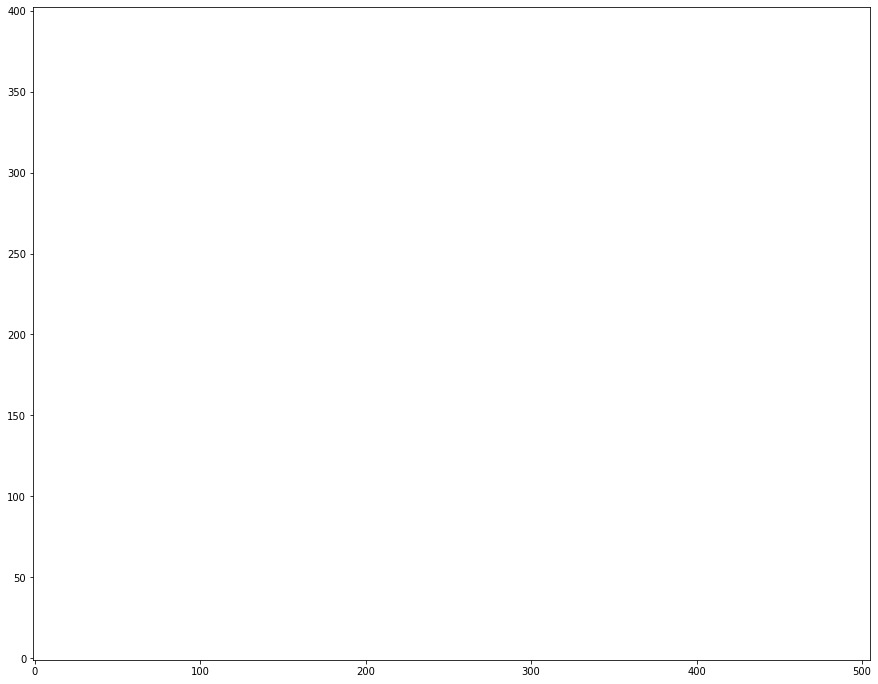

In [306]:
fig = plt.figure(figsize=(15,12))
p1 = fig.add_subplot(111)

p1.set_xlim([-1, xsize])
p1.set_ylim([-1,ysize])



t=np.arange(len(A))
datas=approx(t)

lines=[]
for i in t:
    K=getcircles(500,A,i)
    line1, = p1.plot(np.array(K)[:,0], np.array(K)[:,1],"grey",lw=1,ls="--",alpha=0.7)
    line2, = p1.plot(datas.real[:i+1], datas.imag[:i+1],"black", lw=2,alpha=1)
    line3 = p1.scatter(datas.real[i], datas.imag[i],c='r', marker='o')
    lines.append([line1,line2,line3])

anim = animation.ArtistAnimation(fig, lines, interval=50,blit=True)

#HTML(anim2.to_jshtml())

In [307]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [65]:
H=[[0,1,0,0,0],[1,0,1,0,0],[0,1,0,0,0],[0,0,0,0,1],[0,0,0,1,0]]
scipy.sparse.csgraph.depth_first_order(H,3)

(array([3, 4]), array([-9999, -9999, -9999, -9999,     3]))

In [93]:
test5=list([tuple(l) for l in np.transpose(np.nonzero(A4 == 1))])
getadjm(convertcomplex(test5))

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

def connection(pointA=None, pointB=None):  #points are complex number in matrix coordinates, from A to B
    diff=pointB-pointA
    if diff == diff.real:
        return([complex(i,pointA.imag) for i in np.arange(pointA.real,pointB.real,np.sign(diff))  ][1:])
    elif diff == diff.imag :
        return([complex(pointA.real,i) for i in np.arange(pointA.imag,pointB.imag,np.sign(diff))  ][1:])
    else:
        link=[ pointA + i*(np.sign(diff.real) + np.sign(diff.imag)*1j) for i in np.arange(int(min(abs((pointA-pointB).real),abs((pointA-pointB).imag)))) ]
        if int(abs(link[-1].imag - pointB.imag))==1 :
            s=link[-1].real >= pointB.real
            return(link[1:]+[complex(i,link[-1].imag) for i in np.arange(link[-1].real,pointB.real,-2*s+1)  ][1:])
        else:
            s=link[-1].imag >= pointB.imag
            return(link[1:]+[complex(link[-1].real,i) for i in np.arange(link[-1].imag,pointB.imag,-2*s+1)  ][1:])